
# **Predicting Hit Songs: Can a formula for music business success be created?**
##### **Solomon Onyeke Ameh**

### **Introduction**

Music production has always been attributed to inspiration or talent, with certain artistes and record labels unable to consistently produce record-breaking hit songs [1]. Recently, success in the music industry has been measured more by streaming numbers and popularity on streaming platforms such as Spotify, Apple Music, Deezer, and YouTube Music. These platforms collate data about each song, and this provides an opportunity to further analyze such data and discover hidden patterns that can inform production strategies that ensure an acceptable level of success with each music release. 

Spotify is one of the most popular streaming platforms [2] and via the Spotify API for developers, information consisting of Spotify's audio analysis and descriptive data about each song is easily accessible. The primary aim of this project is to define a relationship between the audio and descriptive features of a song that equate to a hit song.

    Hit Song => f(A,D) where A represents the audio features of a song and D, the descriptive features of a song.  

To achieve the aim of this project, the following objectives are outlined:

1. To gather useful and applicable data from the Spotify API, preprocessing the data to remove null values and possible duplicates.
2. Through exploratory data analysis, visualize the data, identify patterns, correlations, and trends that answer the research questions.
3. To apply data modelling techniques to train and select a model that can be used to predict hit music releases.
4. To package this final model for deployment and use in real world applications. 

The data collection phase is important for the success of this project. By leveraging the Spotify API, a dataset that is not only comprehensive but also current, relevant to modern music trends and captures the various kinds of new music is easily collated. Preprocessing steps such as removing null values and duplicates ensure data quality, which is crucial for accurate analysis and modeling. Through literature review and research in this application area [3],[4], I discovered that the datasets collated by most works are often imbalanced or outdated, making them less applicable for predicting present-day trends and classifying hit songs. Ensuring the dataset includes recent songs addresses this gap and allows the model to be relevant in real-world applications. The collation of low popularity songs is also implemented in a manner that allows an equal spread of songs across genres and time periods. 

The next step is the utilization of Exploratory Data Analysis (EDA) to uncover insights within the dataset. Visualization helps identify patterns, trends, and correlations that may not be immediately obvious from staring at raw data. I can examine what audio or descriptive features are most related to track popularity. EDA also helps to confirm or challenge assumptions about the dataset. 

The predictive modeling phase transforms insights from the data into actionable tools. By training a classification model, I aim to predict the likelihood of a song's success based on its features. This objective is crucial for translating data into a meaningful application that stakeholders in the music industry can rely on. A well-trained model will also highlight which features are most important in the creation of hit songs.

To prepare the final model for deployment, it is packaged into a python pickle (.pkl) which can be easily used by software developers or engineers. Deployment is the culmination of this project, turning theoretical analysis into a practical tool.


### **Research Questions**

1.	What features most significantly influence the likelihood of a song becoming a hit, and do these features vary across genres?
2.	How does the release date (e.g., month, season) impact a song’s popularity, and are certain time frames consistently better for specific genres?
3.	What values of audio features can consistently create a hit song, and how do these values differ across genres?




### **Packages**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import FunctionTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


import joblib

import warnings

warnings.filterwarnings("ignore")

### **The Dataset**


In [2]:
high_popularity_df = pd.read_csv('/kaggle/input/spotify-music-dataset/high_popularity_spotify_data.csv')
low_popularity_df = pd.read_csv('/kaggle/input/spotify-music-dataset/low_popularity_spotify_data.csv')

df = pd.concat([high_popularity_df, low_popularity_df], ignore_index=True)


In [3]:
columns_to_drop = ['time_signature', 'track_href', 'uri', 'analysis_url', 'type']
experiment_df = df.drop(columns=columns_to_drop)
experiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   energy                    4830 non-null   float64
 1   tempo                     4830 non-null   float64
 2   danceability              4830 non-null   float64
 3   playlist_genre            4831 non-null   object 
 4   loudness                  4830 non-null   float64
 5   liveness                  4830 non-null   float64
 6   valence                   4830 non-null   float64
 7   track_artist              4831 non-null   object 
 8   speechiness               4830 non-null   float64
 9   track_popularity          4831 non-null   int64  
 10  track_album_name          4830 non-null   object 
 11  playlist_name             4831 non-null   object 
 12  track_id                  4831 non-null   object 
 13  track_name                4831 non-null   object 
 14  track_al

In [4]:
experiment_df.sample(5, random_state=42)

energy    tempo  danceability playlist_genre  loudness  liveness  \
746   0.5860  189.978        0.3260          latin    -7.966    0.0787   
1550  0.5500  124.130        0.6290        hip-hop    -6.772    0.0950   
4529  0.0525   66.754        0.0658     electronic   -26.699    0.1150   
3749  0.0768  123.193        0.1870      classical   -23.199    0.0911   
3848  0.5240   81.999        0.5790         gospel    -7.764    0.1100   

      valence                                       track_artist  speechiness  \
746    0.2950                                              HUMBE       0.0605   
1550   0.1540                                       Lil Uzi Vert       0.0543   
4529   0.0389                                Christopher Galovan       0.0367   
3749   0.0387  Ēriks Ešenvalds, The Pacific Lutheran Choir Of...       0.0441   
3848   0.7870                                     Anendlessocean       0.0584   

      track_popularity  ... track_album_release_date instrumentalness  \
746                 71  ...               2021-11-11           0.0000   
1550                68  ...               2024-11-01           0.0000   
4529                37  ...               2024-05-10           0.8300   
3749                29  ...               2020-01-17           0.0475   
3848                52  ...               2023-12-01           0.0000   

              track_album_id mode   key  duration_ms acousticness  \
746   2Yjubr5GHX41ht808oZPzs  1.0   6.0     262309.0        0.531   
1550  7awBKnBq0qRLNyD5lI47R0  1.0   0.0     189487.0        0.152   
4529  2e84itcJJkAQ2jYX9e0TVe  1.0   0.0     145267.0        0.925   
3749  1o4x46Hv82vcBRuVZeMe4n  1.0   8.0     235467.0        0.980   
3848  6WRCBHNfy0szRdmgrWbsv6  1.0  10.0     275000.0        0.296   

                          id  playlist_subgenre             playlist_id  
746   0v9UztY5A12cJUsWD7PZzS              chill  0jqQDMmHIkdbkFQdQTlMEQ  
1550  1gUUuh7FQ3mr7nEq0SRvGX            melodic  37i9dQZF1EIgLJJI0PCAq9  
4529  3EzLqzSVxa4Bf1FI7UiCdJ             nordic  54uNB5xGn23ZxdXR1wu84J  
3749  5KCHfR2RGdpieZoQ5NQd5g             choral  37i9dQZF1DX9WxEZbyU6MA  
3848  0D9JNf7ntudlGuRUQW1bXp             modern  4reKL9y3Zh2ccRcBKfAwuz  

[5 rows x 24 columns]

The dataset is collated from Spotify's API using two separate python scripts to extract popular and non-popular songs and their associated audio and descriptive features. Descriptive features of a song include information about the song such as the artist name, album name and release date. Audio features include key, valence , danceability and energy which are results of spotify's audio analysis. The combined features used in the experimentation phase of this project include:


#### Audio Features

| Feature              | Description                                                                                                      |
|-----------------------|------------------------------------------------------------------------------------------------------------------|
| **Energy**           | A measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.|
| **Tempo**            | The speed of a track, measured in beats per minute (BPM).|
| **Danceability**     | A score describing how suitable a track is for dancing based on tempo, rhythm stability, beat strength and overall regularity.|
| **Loudness**         | The overall loudness of a track in decibels (dB). Higher values indicate louder tracks overall.                  |
| **Liveness**         | The likelihood of a track being performed live. Higher values suggest more audience presence.          |
| **Valence**          | The overall musical positiveness(emotion) of a track. High valence sounds happy; low valence sounds sad or angry.|
| **Speechiness**      | Measures the presence of spoken words.                        |
| **Instrumentalness** | The likelihood a track contains no vocals. Values closer to 1.0 suggest solely instrumental tracks.                   |
| **Mode**             | Indicates the modality of the track.              |
| **Key**              | The musical key, represented as an integer from 0 to 11, mapping to standard Pitch class notation.                 |
| **Duration_ms**      | The length of the track in milliseconds.                                                                        |
| **Acousticness**     | A confidence measure of whether a track is acoustic(1) or not(0).                  |

#### Descriptive Features

| Feature                     | Description                                                                                  |
|-----------------------------|----------------------------------------------------------------------------------------------|
| **Track Name**              | The name of the track.                                                                       |
| **Track Artist**            | The artist(s) performing the track.                                                         |
| **Track Album Name**        | The album in which the track is featured.                                                   |
| **Track Album Release Date**| The release date of the album containing the track.                                         |
| **Track ID**                | A unique identifier assigned to the track by Spotify.                                       |
| **Track Album ID**          | A unique identifier for the album.                                                          |
| **Playlist Name**           | The name of the playlist where the track is included.                                       |
| **Playlist Genre**          | The main genre associated with the playlist (e.g., pop, rock, classical).                   |
| **Playlist Subgenre**       | A more specific subgenre tied to the playlist (e.g., indie pop, punk rock).                 |
| **Playlist ID**             | A unique identifier for the playlist.                                                      |
| **Track Popularity**        | A score (0–100) which is calculated based on total number of streams in relation to other songs.              |


In [5]:
experiment_df.describe().T

count           mean           std           min  \
energy            4830.0       0.586691      0.246263      0.000202   
tempo             4830.0     118.269293     28.512615     48.232000   
danceability      4830.0       0.622311      0.187706      0.058900   
loudness          4830.0      -9.281627      7.129396    -48.069000   
liveness          4830.0       0.167613      0.124429      0.021000   
valence           4830.0       0.481930      0.258036      0.029600   
speechiness       4830.0       0.101738      0.101032      0.021900   
track_popularity  4831.0      54.761126     19.828573     11.000000   
instrumentalness  4830.0       0.201053      0.351918      0.000000   
mode              4830.0       0.562112      0.496178      0.000000   
key               4830.0       5.233333      3.580857      0.000000   
duration_ms       4830.0  206150.818219  81745.555294  35375.000000   
acousticness      4830.0       0.341217      0.325382      0.000004   

                            25%            50%           75%          max  
energy                 0.442250       0.633000       0.77700        0.998  
tempo                 96.063000     118.059500     136.72350      241.426  
danceability           0.525000       0.653000       0.75800        0.979  
loudness             -10.297750      -7.191000      -5.33675        1.318  
liveness               0.095400       0.118000       0.19500        0.979  
valence                0.275000       0.483000       0.69000        0.987  
speechiness            0.038600       0.056100       0.11800        0.927  
track_popularity      41.000000      56.000000      72.00000      100.000  
instrumentalness       0.000000       0.000091       0.20050        0.991  
mode                   0.000000       1.000000       1.00000        1.000  
key                    2.000000       5.000000       8.00000       11.000  
duration_ms       159000.000000  194866.500000  233478.00000  1355260.000  
acousticness           0.052925       0.224500       0.59000        0.996

### **Data Preprocessing**


In [6]:
duplicates =  experiment_df[experiment_df.duplicated(subset=['id'])]
duplicates = duplicates.shape[0]

print(f"Number of duplicate tracks: {duplicates}")

Number of duplicate tracks: 336


Duplicate tracks exist in this data as one song can appear in multiple playlists. 

In [7]:
experiment_df = experiment_df.drop_duplicates(subset=['id'])

print(f"After removing duplicates, we have {experiment_df.shape[0]} songs left.")

After removing duplicates, we have 4495 songs left.


In [8]:
experiment_df.isnull().sum()

energy                      1
tempo                       1
danceability                1
playlist_genre              0
loudness                    1
liveness                    1
valence                     1
track_artist                0
speechiness                 1
track_popularity            0
track_album_name            1
playlist_name               0
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            1
track_album_id              0
mode                        1
key                         1
duration_ms                 1
acousticness                1
id                          1
playlist_subgenre           0
playlist_id                 0
dtype: int64

In [9]:
experiment_df = experiment_df.dropna()
experiment_df.isnull().sum()

energy                      0
tempo                       0
danceability                0
playlist_genre              0
loudness                    0
liveness                    0
valence                     0
track_artist                0
speechiness                 0
track_popularity            0
track_album_name            0
playlist_name               0
track_id                    0
track_name                  0
track_album_release_date    0
instrumentalness            0
track_album_id              0
mode                        0
key                         0
duration_ms                 0
acousticness                0
id                          0
playlist_subgenre           0
playlist_id                 0
dtype: int64

In [10]:
def convert_to_datetime(df):
    df = df.copy()
    df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
    return df

def extract_year_and_month(df):
    df = df.copy()
    df['track_album_release_year'] = df['track_album_release_date'].dt.year
    df['track_album_release_month'] = df['track_album_release_date'].dt.month
    return df


def classify_seasons(df):
    df = df.copy()

    def seasons_classification(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'

    df['track_album_release_season'] = df['track_album_release_month'].apply(seasons_classification)
    return df


date_pipeline = Pipeline([
    ('to_datetime', FunctionTransformer(convert_to_datetime)),
    ('extract_year_month', FunctionTransformer(extract_year_and_month)),
    ('classify_seasons', FunctionTransformer(classify_seasons)),
])



In [11]:
def encode_playlist_genre(df):
    df = df.copy()
    playlist_genre_label_encoder = LabelEncoder()
    df['playlist_genre_encoded'] = playlist_genre_label_encoder.fit_transform(df['playlist_genre'])

    # print("Playlist Genre Label Mapping:")
    # for label, encoded_label in zip(playlist_genre_label_encoder.classes_, range(len(playlist_genre_label_encoder.classes_))):
    #     print(f"{label}: {encoded_label}")

    return df


def encode_playlist_subgenre(df):
    df = df.copy()
    playlist_subgenre_label_encoder = LabelEncoder()
    df['playlist_subgenre_encoded'] = playlist_subgenre_label_encoder.fit_transform(df['playlist_subgenre'])

    # print("Playlist Genre Label Mapping:")
    # for label, encoded_label in zip(playlist_subgenre_label_encoder.classes_, range(len(playlist_subgenre_label_encoder.classes_))):
    #     print(f"{label}: {encoded_label}")

    return df


def encode_album_release_season(df):
    df = df.copy()
    track_album_release_season_label_encoder = LabelEncoder()
    df['track_album_release_season_encoded'] = track_album_release_season_label_encoder.fit_transform(df['track_album_release_season'])

    # print("Playlist Genre Label Mapping:")
    # for label, encoded_label in zip(track_album_release_season_label_encoder.classes_, range(len(track_album_release_season_label_encoder.classes_))):
    #     print(f"{label}: {encoded_label}")

    return df


encoding_pipeline = Pipeline([
    ('encode_playlist_genre', FunctionTransformer(encode_playlist_genre)),
    ('encode_playlist_subgenre', FunctionTransformer(encode_playlist_subgenre)),
    ('encode_album_release_season', FunctionTransformer(encode_album_release_season)),
])



Label encoders are used here because the categorical data being processed (playlist genres, subgenre, and album release seasons) has no inherent order or hierarchy. By assigning a unique integer value to each category, label encoders efficiently transform textual data into a numeric format suitable for machine learning models. This approach is memory-efficient compared to other encoding techniques, such as one-hot encoding so it is particularly an advantage when dealing with datasets that have a large number of distinct categories such as the genre and subgenre features.

In [12]:
experiment_df = date_pipeline.fit_transform(experiment_df)
experiment_df = encoding_pipeline.fit_transform(experiment_df)
experiment_df = experiment_df.dropna()
experiment_df.head()

energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.592  157.969         0.521            pop    -7.777     0.122    0.535   
1   0.507  104.978         0.747            pop   -10.171     0.117    0.438   
2   0.808  108.548         0.554            pop    -4.169     0.159    0.372   
3   0.910  112.966         0.670            pop    -4.070     0.304    0.786   
4   0.783  149.027         0.777            pop    -4.477     0.355    0.939   

            track_artist  speechiness  track_popularity  ... acousticness  \
0  Lady Gaga, Bruno Mars       0.0304               100  ...       0.3080   
1          Billie Eilish       0.0358                97  ...       0.2000   
2          Gracie Abrams       0.0368                93  ...       0.2140   
3      Sabrina Carpenter       0.0634                81  ...       0.0939   
4       ROSÉ, Bruno Mars       0.2600                98  ...       0.0283   

                       id playlist_subgenre             playlist_id  \
0  2plbrEY59IikOBgBGLjaoe        mainstream  37i9dQZF1DXcBWIGoYBM5M   
1  6dOtVTDdiauQNBQEDOtlAB        mainstream  37i9dQZF1DXcBWIGoYBM5M   
2  7ne4VBA60CxGM75vw0EYad        mainstream  37i9dQZF1DXcBWIGoYBM5M   
3  1d7Ptw3qYcfpdLNL5REhtJ        mainstream  37i9dQZF1DXcBWIGoYBM5M   
4  5vNRhkKd0yEAg8suGBpjeY        mainstream  37i9dQZF1DXcBWIGoYBM5M   

  track_album_release_year  track_album_release_month  \
0                   2024.0                        8.0   
1                   2024.0                        5.0   
2                   2024.0                       10.0   
3                   2024.0                        8.0   
4                   2024.0                       10.0   

  track_album_release_season  playlist_genre_encoded  \
0                     Summer                      25   
1                     Spring                      25   
2                       Fall                      25   
3                     Summer                      25   
4                       Fall                      25   

   playlist_subgenre_encoded  track_album_release_season_encoded  
0                         55                                   2  
1                         55                                   1  
2                         55                                   0  
3                         55                                   2  
4                         55                                   0  

[5 rows x 30 columns]

In [13]:
experiment_df.isnull().sum()

energy                                0
tempo                                 0
danceability                          0
playlist_genre                        0
loudness                              0
liveness                              0
valence                               0
track_artist                          0
speechiness                           0
track_popularity                      0
track_album_name                      0
playlist_name                         0
track_id                              0
track_name                            0
track_album_release_date              0
instrumentalness                      0
track_album_id                        0
mode                                  0
key                                   0
duration_ms                           0
acousticness                          0
id                                    0
playlist_subgenre                     0
playlist_id                           0
track_album_release_year              0


### **Exploratory Data Analysis (EDA)**


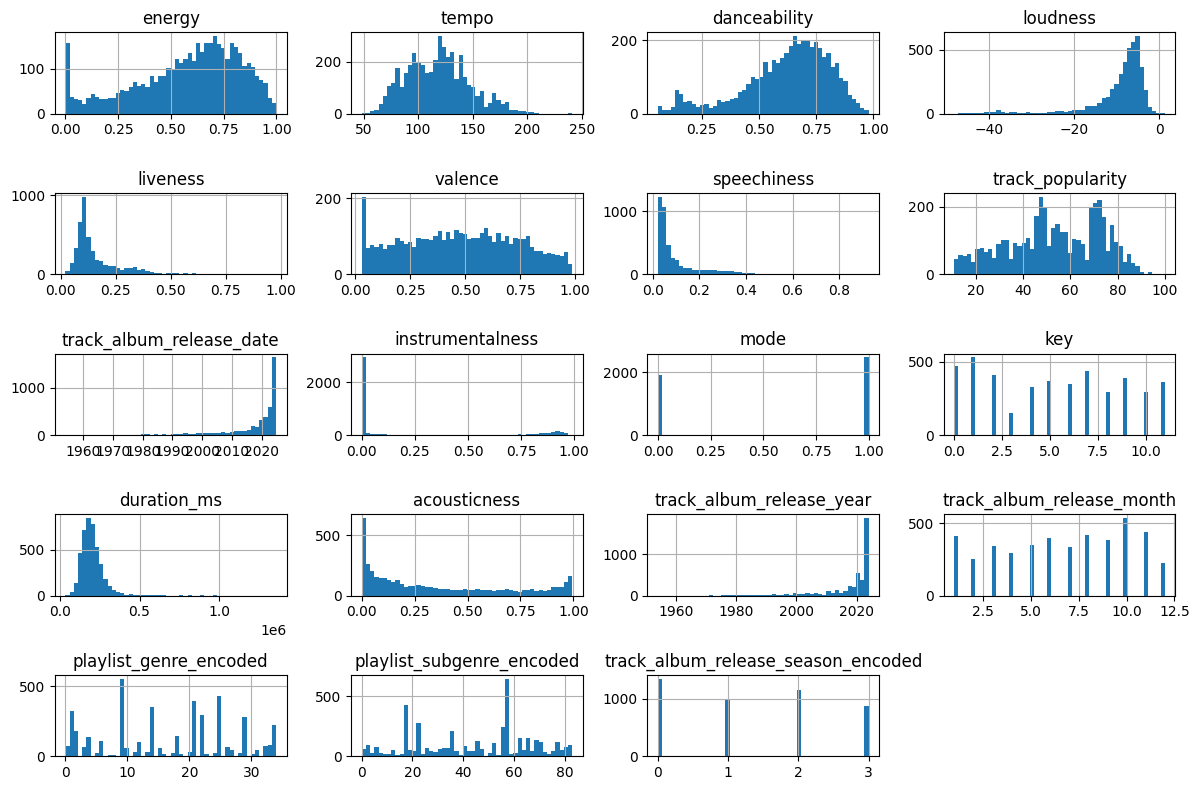

In [14]:
experiment_df.hist(bins = 50, figsize=(12,8))
plt.tight_layout()
plt.show()

The histogram plot of each feature in the transformed dataframe describes the distribution of the features in the dataset. From the plots, we notice that most features range from 0 to 1,  while certain features such as tempo have a wider range from 0 to 250. This indicates that to ensure that the final trained model will not be biased towards features with a larger scale, a standard scaler is required. To check if the dataset is biased towards any particular genre, a plot of the genres spread is analyzed below.

<Axes: ylabel='count'>

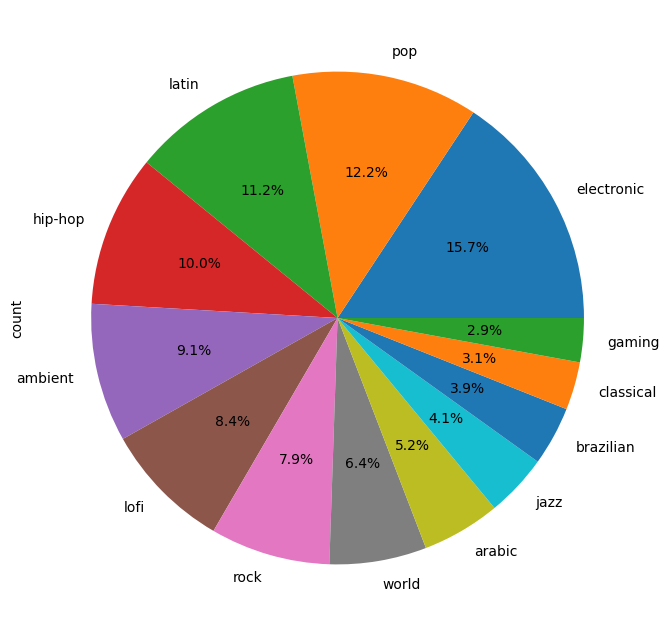

In [15]:
genre_counts = experiment_df.playlist_genre.value_counts()
genre_counts_top_10 = genre_counts.nlargest(13)

plt.figure(figsize=(10, 8))
genre_counts_top_10.plot.pie(autopct='%1.1f%%')

This is a fairly balanced spread of the genres in the dataset considering there are certain genres that are more popular than others and music production in certain genres are also more frequent than others. There are more songs released each year in pop or electronic than there is in classical music.

In [16]:
genre_popularity = experiment_df.groupby('playlist_genre')['track_popularity'].mean()
genre_popularity_top_10 = genre_popularity.nlargest(10)

print("Average popularity of each genre:")
print(genre_popularity_top_10.sort_values(ascending=False))

Average popularity of each genre:
playlist_genre
r&b        76.437500
gaming     69.401961
k-pop      68.500000
metal      66.653846
punk       66.246154
rock       65.169065
j-pop      64.956522
hip-hop    62.019886
pop        61.960648
korean     61.687500
Name: track_popularity, dtype: float64


The information above shows the top 10 popular genres from the dataset, a conclusion we can draw from this, is that r&b music stays the most popular genre to make music in. This supports a bold claim that songs focused on love, relationships and emotions sell better than others. Gaming playlists are a combination of different song genres used in multiple games, this points to the claim that having your song released for use on popular games can increase popularity immensely.

([<matplotlib.axis.XTick at 0x7e64c2672320>,
 [Text(0, 0, '0'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '80'),
  Text(90, 0, '90')])

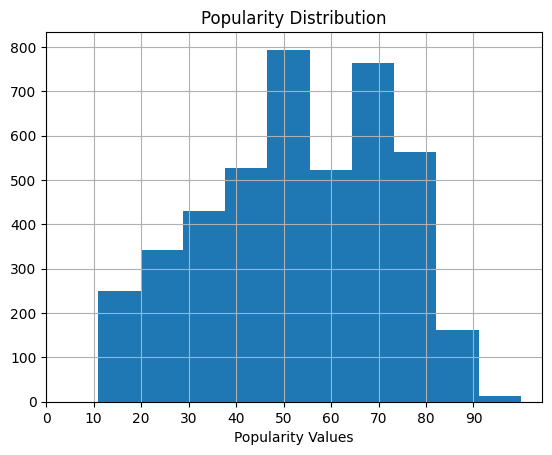

In [17]:
experiment_df.track_popularity.hist()
plt.title('Popularity Distribution')

plt.xlabel('Popularity Values')

plt.xticks(range(0, 100, 10))

This histogram represents the distribution of the track popularity in the dataset. With peaks observed around the ranges of 45 to 55 and 65 to 75. Past works have used these peaks to classify the thresholds for popularity, however, for this project I experimented with the threshold set to a real world categorization of hit songs. The lowest-ranked song on the Billboard Top 100 was used as a benchmark and Meghan Trainor's Criminal had a popularity score of 71. This was used as a reference point and the threshold was set slightly below this value at 68. This value also falls in one of the peaks of this distribution. 

<Axes: >

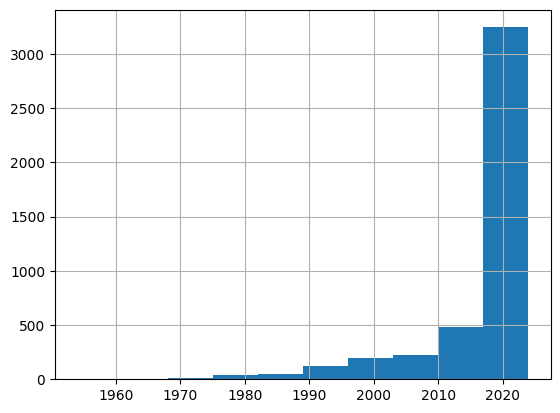

In [18]:
experiment_df.track_album_release_year.hist()

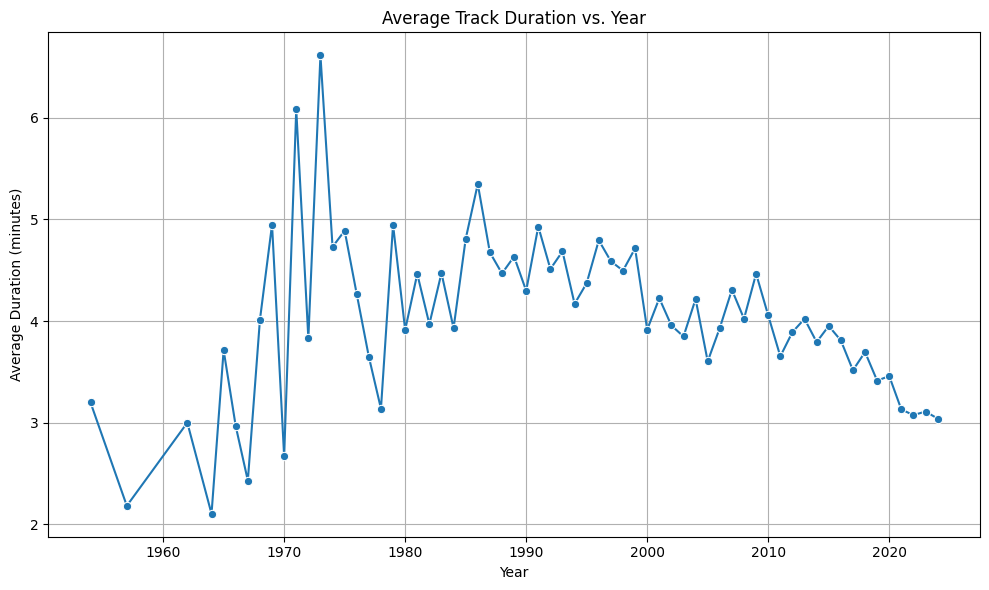

In [19]:
yearly_avg_duration = experiment_df.groupby('track_album_release_year')['duration_ms'].mean().reset_index()

yearly_avg_duration['track_duration_min'] = yearly_avg_duration['duration_ms'] / 60000

plt.figure(figsize=(10, 6))
sns.lineplot(data=yearly_avg_duration, x='track_album_release_year', y='track_duration_min', marker='o')

plt.title('Average Track Duration vs. Year')
plt.xlabel('Year')
plt.ylabel('Average Duration (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

The line plot illustrates the average track duration (in minutes) over the years, revealing notable trends in song lengths. By the 2020s, the average track duration drops to just over 3 minutes, reflecting modern music trends that prioritize shorter, more concise songs suitable for streaming platforms and attention spans of contemporary listeners. This evolution highlights how industry standards and consumer preferences have changed over time.

<Axes: >

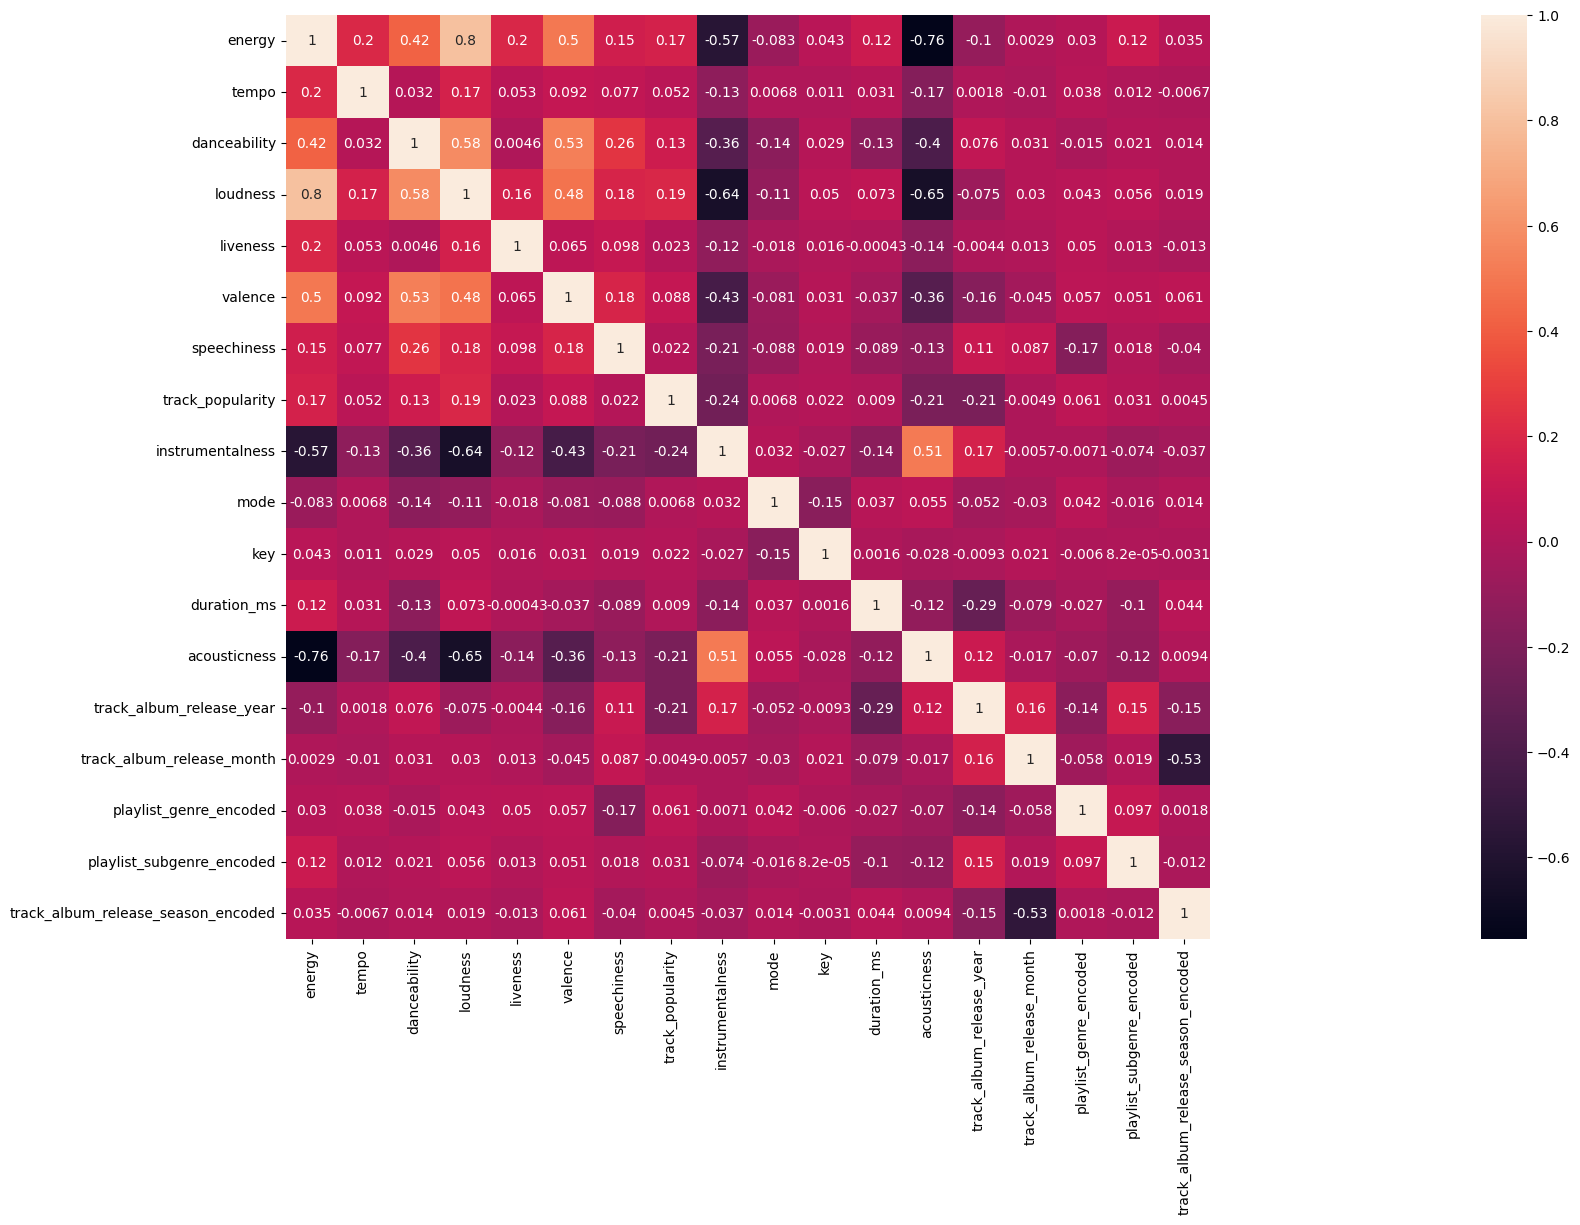

In [20]:
corr = experiment_df.corr(numeric_only=True)

fig, ax = plt.subplots(figsize = (16,12))
fig.set_size_inches(70,12)
sns.heatmap(corr,square=True, annot=True)

The heatmap plot above highlights the correlations between various features in the dataset. One of the most notable relations is the positive correlation between "energy" and "track_popularity". Tracks with higher energy levels tend to perform better in terms of popularity. This makes sense given that energetic songs are frequently associated with genres like pop, electronic, and dance music, which dominate streaming platforms, club playlists, social media and resonate with mainstream audiences. These tracks are often played in social settings such as parties or workout playlists, amplifying their reach and popularity.

Similarly, "danceability" and "loudness" show a modest positive correlation with "track_popularity". Danceable tracks are easier to engage with, making them more likely to be shared and replayed. Loudness, which reflects the intensity of a track, is another factor that can contribute to its appeal, especially in this era of social media consumption. On the other hand, "instrumentalness" exhibits a relatively strong negative correlation with "track_popularity." Instrumental tracks, while appreciated in niche genres or as background music, generally lack the widespread appeal needed for mainstream success, highlighting the importance of vocals in popular music. Another interesting relationship is the one between "acousticness" and "track_popularity," which shows a negative correlation. Acoustic tracks seem to resonate less with mainstream audiences. This trend may reflect the dominance of electronic music in charts, which offers a sound that appeals to broader listener demographics. While acoustic tracks can still gain traction, their appeal may be more limited to specific genres or settings.

The insights from these correlations also inform feature selection for the data modelling phase. The release year of a song is closely related to its track popularity, which is understandable since recently released songs tend to be more popular. However for this experimentation, I chose to exclude the release year as a feature. Instead, I focused on examining the influence of release months and seasons on song popularity, as these are features that artist can easily make changes to. 

### **Data Modelling**


In [21]:
# Create a new column to label songs as "hit" (1) or "non-hit" (0)
experiment_df['track_popularity_cat'] = (experiment_df['track_popularity'] > 68).astype(int)

experiment_df[['track_popularity', 'track_popularity_cat']].sample(5)

track_popularity  track_popularity_cat
3005                45                     0
3184                18                     0
4579                27                     0
4822                19                     0
3755                37                     0

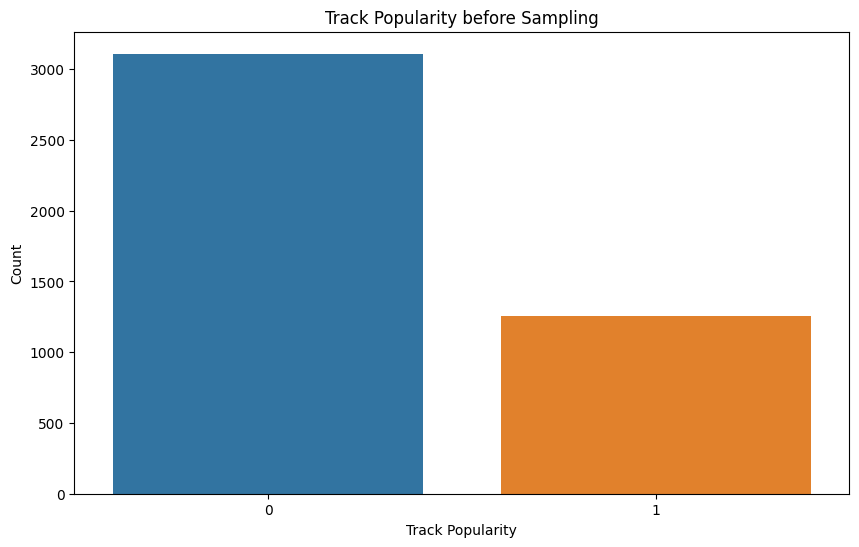

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(data=experiment_df, x='track_popularity_cat')
plt.title('Track Popularity before Sampling')
plt.xlabel('Track Popularity')
plt.ylabel('Count')
plt.show()

In [23]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','playlist_subgenre_encoded', 'playlist_genre_encoded', 'track_album_release_season_encoded', 'track_album_release_month']

X = experiment_df[features]
y = experiment_df['track_popularity_cat']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=experiment_df['track_popularity_cat'])

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f'Original dataset shape: {X.shape}')

print(f'Resampled dataset shape: {X_train_smote.shape}')

Original dataset shape: (4368, 15)
Resampled dataset shape: (4974, 15)


In [24]:
from collections import Counter

print('Original dataset shape:', Counter(y))

print('Resampled dataset shape:', Counter(y_train_smote))

Original dataset shape: Counter({0: 3109, 1: 1259})
Resampled dataset shape: Counter({0: 2487, 1: 2487})


The dataset was divided into separate training and test sets to ensure a good evaluation of the model's performance. Using a train-test split, 80% of the data was allocated for training the model, while the remaining 20% separated for testing. To ensure the distribution of the target variable (track_popularity_cat) is the same in both sets, stratified sampling is used. This ensures that each popularity category is proportionally represented in both the training and test datasets, avoiding bias.

To address the potential issue of class imbalance in the training data, Synthetic Minority Oversampling Technique (SMOTE) was applied. SMOTE generates synthetic samples for the minority classes by interpolating between existing samples, balancing the class distribution. This resampling technique enhances the model's ability to learn from the minority class, reducing the risk of biased predictions favoring majority classes. After applying SMOTE, the class imbalance was mitigated. The original dataset's shape increased significantly, as indicated by the shape of X_train_smote, allowing the model to train on a more balanced dataset. This preprocessing step is critical when working with imbalanced datasets, as it provides balance and improves the predictive accuracy across all classes.

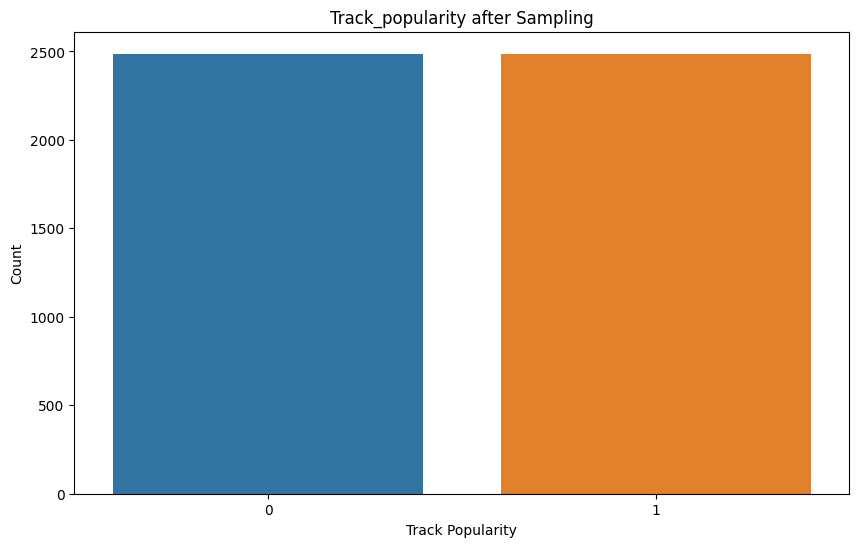

In [25]:
y_train_smote_df = pd.DataFrame({'track_popularity_cat': y_train_smote})

plt.figure(figsize=(10, 6))
sns.countplot(data=y_train_smote_df, x='track_popularity_cat')
plt.title('Track_popularity after Sampling')
plt.xlabel('Track Popularity')
plt.ylabel('Count')
plt.show()

The plot displays the distribution of the "track_popularity" feature after applying a sampling technique, resulting in a perfectly balanced dataset. The bars indicate that the number of tracks with low popularity (label 0) is now equal to the number of highly popular tracks (label 1). The imbalance in popularity is common in music datasets, as only a small proportion of songs tend to achieve significant popularity, while the rest remain less popular or streamed.

In [26]:
# Define the models
model_dict = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boost': GradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Extra Tree': ExtraTreesClassifier(),
    'XGBoost': XGBClassifier(),          
    'LightGBM': LGBMClassifier(),      
    'DummyClassifier': DummyClassifier(strategy='most_frequent' ,random_state=42)
}

In [27]:
def fit_and_score (models, x_train, x_test, y_train, y_test):
    
    np.random.seed(42)
    model_accuracy = {}
    
    for name, model in models.items():
        model.fit(x_train, y_train)
        model_accuracy[name] = model.score(x_test, y_test)
        
    return model_accuracy

In [28]:
model_accuracy = fit_and_score(model_dict, X_train_smote, X_test,y_train_smote, y_test)
model_accuracy

[LightGBM] [Info] Number of positive: 2487, number of negative: 2487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 4974, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


{'Logistic Regression': 0.6430205949656751,
 'KNN': 0.6704805491990846,
 'Random Forest': 0.8192219679633868,
 'Gradient Boost': 0.8043478260869565,
 'AdaBoost': 0.7597254004576659,
 'Extra Tree': 0.7951945080091534,
 'XGBoost': 0.8466819221967964,
 'LightGBM': 0.8569794050343249,
 'DummyClassifier': 0.7116704805491991}

The results of the model accuracy comparisons reveal notable differences in the performance of various classification algorithms. Logistic Regression, a baseline linear model, achieved an accuracy of approximately 63%. While this performance is reasonable, it is significantly outperformed by most of the other models. The K-Nearest Neighbors (KNN) algorithm performed slightly better, achieving an accuracy of 67%. However, both models struggled to capture the complexity of the data compared to more advanced ensemble methods.

Ensemble models such as Random Forest, Gradient Boost, and AdaBoost showed substantial improvements. Random Forest achieved an accuracy of 82%, while Gradient Boost achieved an accuracy of 81%. AdaBoost followed closely with a 77% accuracy, reflecting the strength of boosting algorithms in handling complex datasets. The Extra Tree classifier performed similarly to Random Forest with an 81% accuracy, leveraging decision trees to achieve strong predictive power.

The DummyClassifier, which serves as a baseline reference, achieved an accuracy of 71.17%. This relatively high baseline suggests that the dataset's target variable has some inherent structure that even random predictions can partially capture. Among all models, the XGBoost and LightGBM classifiers achieved the highest accuracies, with XGBoost reaching 84.3% and LightGBM leading with 84.4%. These results highlight the efficiency of gradient boosting algorithms, particularly LightGBM, which is known for its speed and scalability. 


### **Dummy Classifier**


In [29]:
dummy_model = DummyClassifier()

dummy_model.fit(X_train_smote,y_train_smote)

y_pred = dummy_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      1.00      0.83       622
           1       0.00      0.00      0.00       252

    accuracy                           0.71       874
   macro avg       0.36      0.50      0.42       874
weighted avg       0.51      0.71      0.59       874



To set a baseline for experimentation, I used a dummy classifier with the strategy set to 'most_frequent'. This classifier provides comparison and also highlights the challenges of the imbalanced dataset. It achieves an accuracy of 71%, but this is misleading as it classifies all samples as the majority class (no hit). The precision and recall for the positive class (hit) are 0.00, resulting in an F1-score of 0.00. This emphasizes the importance of considering precision, recall, and F1-score in imbalanced datasets, as high accuracy can mask poor performance on minority classes.


### **Random Forest**


              precision    recall  f1-score   support

           0       0.86      0.87      0.86       622
           1       0.67      0.64      0.65       252

    accuracy                           0.81       874
   macro avg       0.76      0.76      0.76       874
weighted avg       0.80      0.81      0.80       874



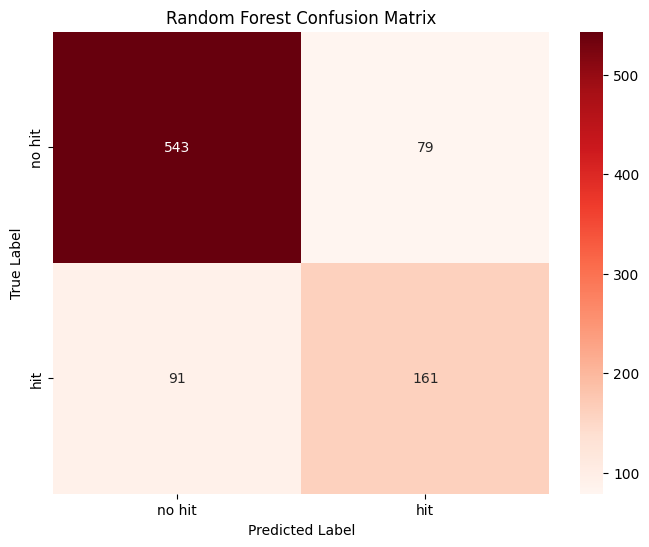

In [30]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train_smote,y_train_smote)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

conf_mat_rf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))

sns.heatmap(conf_mat_rf, annot=True, cmap='Reds', fmt='g', xticklabels=['no hit', 'hit'], yticklabels=['no hit', 'hit'])

plt.title('Random Forest Confusion Matrix')

plt.xlabel('Predicted Label')

plt.ylabel('True Label')

plt.show()

The results from experimenting with the random forest model show that the model performs better than the baseline dummy classifier. It has a higher accuracy and it's precision in predicting the positive class is about 70%. This is a significant improvement, however it still indicates that accuracy alone cannot be used as the metric in this project experimentation. The precision for the negative class is significantly higher than the precision for the positive class, which points to the imbalance in the dataset. The confusion matrix also shows that 170 out of 252 hits are correctly identified, but 82 hits are misclassified as no hit. This indicates that while the model is learning from the minority class, it still struggles to balance precision and recall.



### **LightGBM Model**


[LightGBM] [Info] Number of positive: 2487, number of negative: 2487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 4974, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       622
           1       0.77      0.71      0.74       252

    accuracy                           0.86       874
   macro avg       0.83      0.81      0.82       874
weighted avg       0.85      0.86      0.86       874



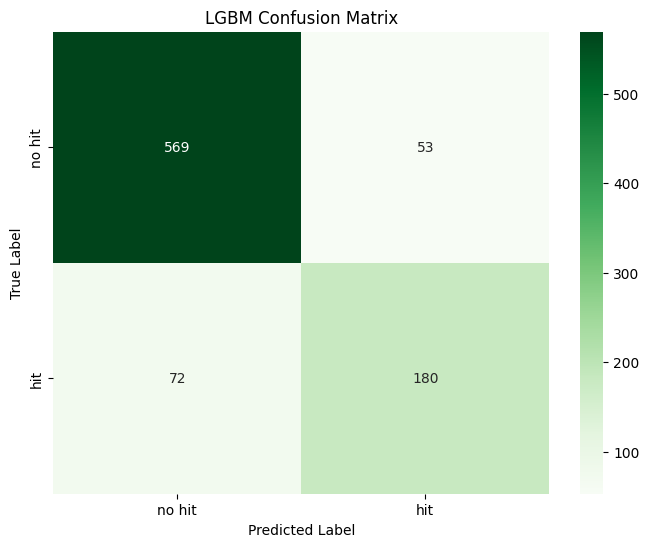

In [31]:
lgbm_model = LGBMClassifier()

lgbm_model.fit(X_train_smote, y_train_smote)

y_pred = lgbm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

conf_mat_lgbm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))

sns.heatmap(conf_mat_lgbm, annot=True, cmap='Greens', fmt='g', xticklabels=['no hit', 'hit'], yticklabels=['no hit', 'hit'])

plt.title('LGBM Confusion Matrix')

plt.xlabel('Predicted Label')

plt.ylabel('True Label')

plt.show()

The Light Gradient Boosting Machine (LGBM) model is the best performing model for this dataset. The results from the experimentation show that the accuracy of this model in predicting test data is approximately 84%. The precision score is also significantly better at a value of 76%, however recall is still around 69%. The performance of this model demonstrates it's ability to map to complex relationships and also imbalanced datasets. The Light Gradient Boosting Machine (LightGBM) is an open-source gradient-boosting framework developed by Microsoft, specifically tailored for high efficiency and scalability. It is built on the concept of decision tree algorithms, using a gradient boosting approach where subsequent trees aim to correct the errors in previous trees. It uses a leaf-wise growth strategy which optimizes the leaf with the highest loss reduction, resulting in more accurate trees [5]. This makes LightGBM both faster and more efficient than traditional level-wise methods, although it requires careful training and tuning to avoid overfitting. In the following sections, I tune the hyperparameter of this model to obtain the best performance for the model.

### **Hyper-parameter Tuning**


In [32]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

[LightGBM] [Info] Number of positive: 2487, number of negative: 2487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3430
[LightGBM] [Info] Number of data points in the train set: 4974, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

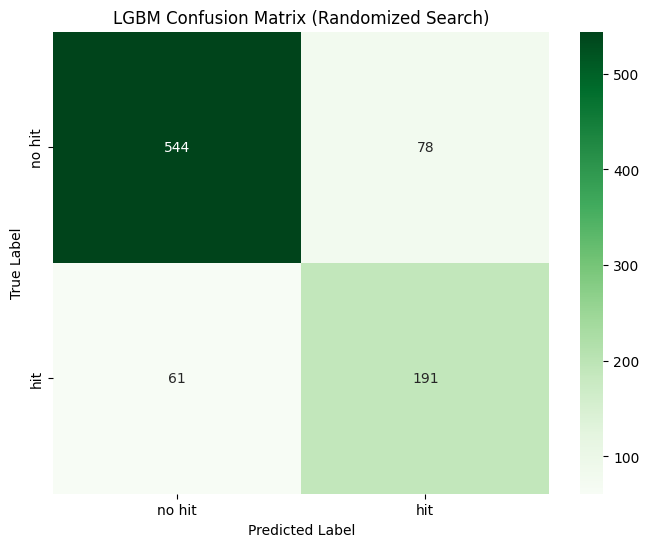

In [33]:

param_dist = {
    'n_estimators': [200, 250, 300],         
    'learning_rate': [0.03, 0.05, 0.1],     
    'max_depth': [7, 10, 12],               
    'num_leaves': [40, 50, 60],             
    'subsample': [0.7, 0.8, 1.0],           
    'colsample_bytree': [0.8, 0.9, 1.0],    
    'min_child_weight': [3, 5, 7],          
    'scale_pos_weight': [2, 3, 4],          
    'reg_alpha': [0.1, 1, 10],              
    'reg_lambda': [10, 50, 100]             
}



random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=50,                
    scoring='accuracy',       
    cv=5,                     
    verbose=0,                
    random_state=42,
    n_jobs=-1                 
)


random_search.fit(X_train_smote, y_train_smote)


print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)


best_lgbm_model = random_search.best_estimator_
y_pred = best_lgbm_model.predict(X_test)


print("Classification Report:")
print(classification_report(y_test, y_pred))


conf_mat_lgbm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_lgbm, annot=True, cmap='Greens', fmt='g', xticklabels=['no hit', 'hit'], yticklabels=['no hit', 'hit'])
plt.title('LGBM Confusion Matrix (Randomized Search)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The results of the hyperparameter tuning process do not significantly affect the accuracy of the model, however the recall value is increased to 72%. This produces the best LGBM model which is used to draw conclusions and answer the research questions. 

### **Research Question 1**


In [34]:
feature_importance = pd.DataFrame({'Importance':best_lgbm_model.feature_importances_, 'Features':features})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance


Importance                            Features
11        1449           playlist_subgenre_encoded
12        1105              playlist_genre_encoded
8          916                            liveness
10         891                               tempo
9          882                             valence
0          867                        danceability
3          813                            loudness
6          810                        acousticness
2          790                                 key
1          768                              energy
5          756                         speechiness
7          674                    instrumentalness
14         582           track_album_release_month
13         260  track_album_release_season_encoded
4           67                                mode

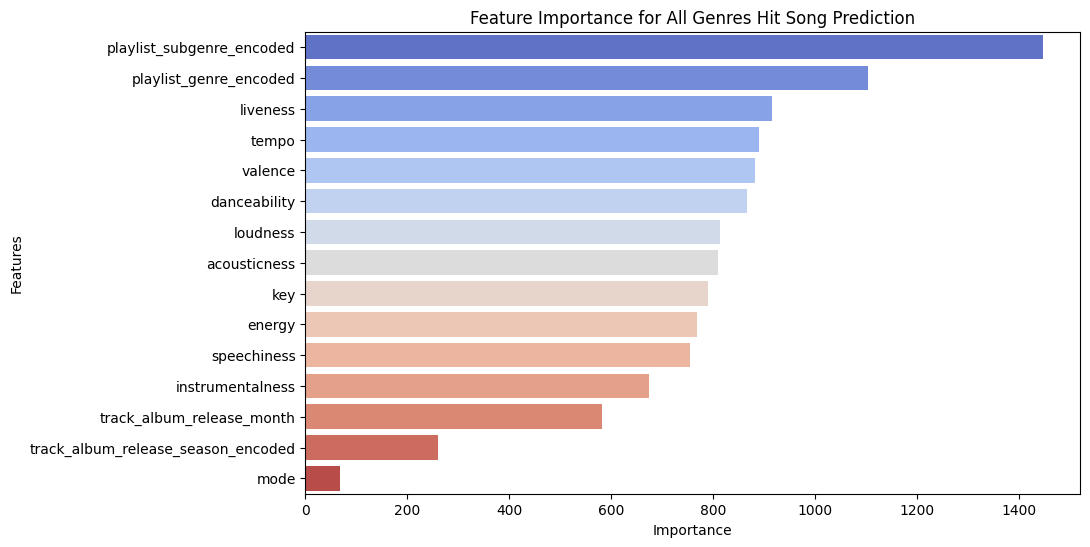

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=feature_importance, palette='coolwarm')
plt.title('Feature Importance for All Genres Hit Song Prediction')
plt.show()

The feature importance plot computed from the LGBM model above identify which features contribute more to the popularity of a song. The most important features being the subgenre or genre of music produced. This claim makes sense as certain genres are more commercial compared to others which probably serve a niche audience. This points to a conclusion that a genre such as 'pop' or 'electronic' would dominate mainstream media more than a niche 'throat-singing' genre. This conclusive statement can inform music producers, artists and labels on what kind of music to produce more frequently. The insights from the data exploration phase point to genres such as r&b, pop and hip-hop being the more popular genres to choose from. 

The most important audio features emerging from this exploration being 'liveness', 'danceability' and 'valence' points to the importance of producing songs which are more performable in concerts, danceable and influential to moods. Danceable songs are also easier to market and push on social media platforms such as TikTok and Instagram. Similarly, production features like "speechiness," "acousticness," and "tempo" are ranked highly, emphasizing the importance of dynamic and engaging production styles. This supports the conclusion that a poorly developed music production would struggle to gain any attention or popularity. 

At the lower end of the importance spectrum are features like "mode," "track_album_release_month," and "track_album_release_season_encoded." While these factors may still influence popularity, their impact is relatively minor compared to genre and production elements. This indicates that the tonal structure of a song or the season of its release plays a smaller role in determining its success. In the following section, I aim to discover how the importance of these audio features may differ for different genres. 

Analyzing genre: pop
0.9310344827586207
Analyzing genre: rock
0.6785714285714286
Analyzing genre: hip-hop
0.6901408450704225
Analyzing genre: latin
0.6708860759493671
Analyzing genre: electronic
0.8648648648648649
Analyzing genre: lofi
0.9833333333333333


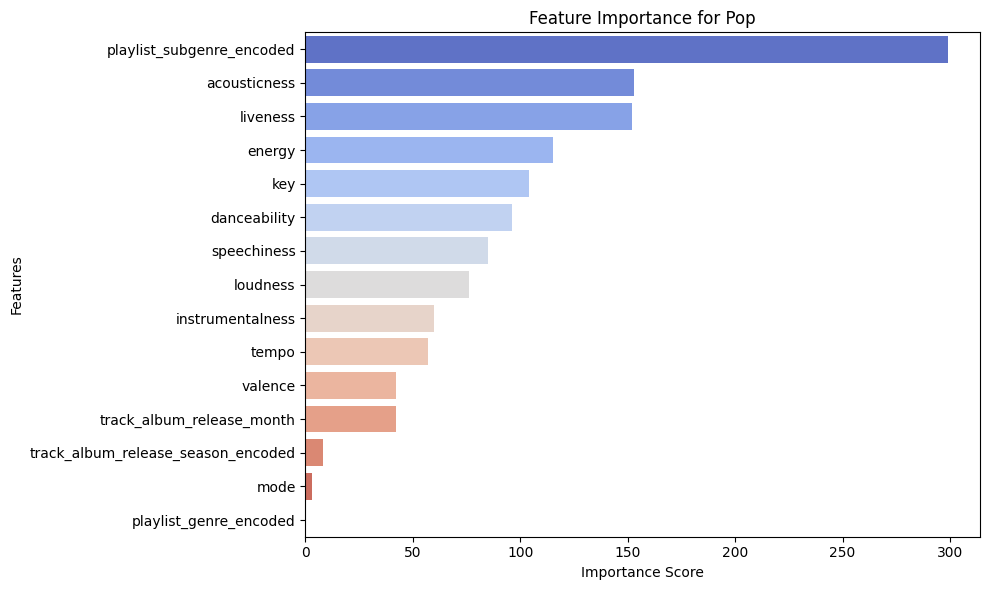

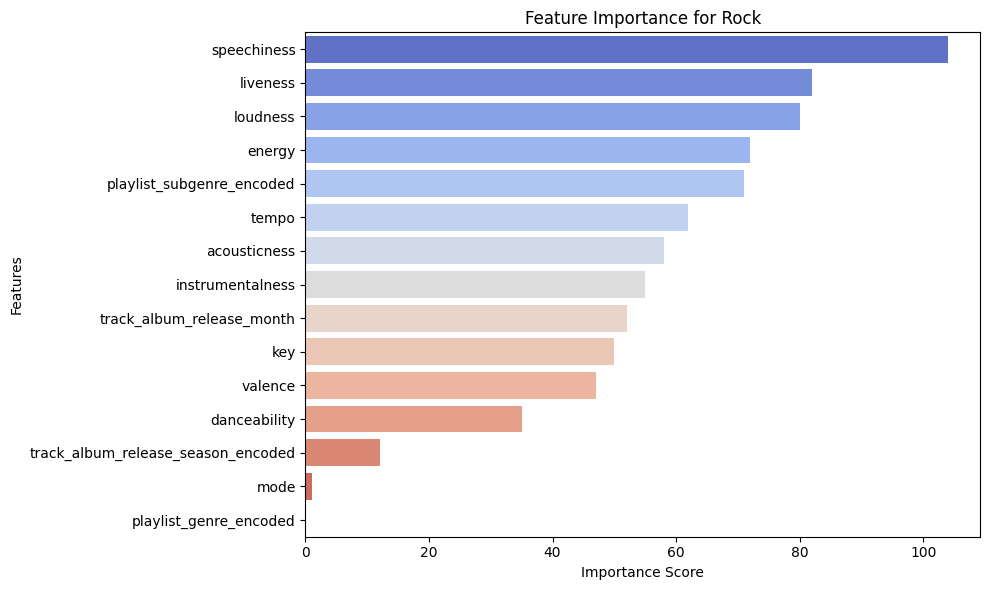

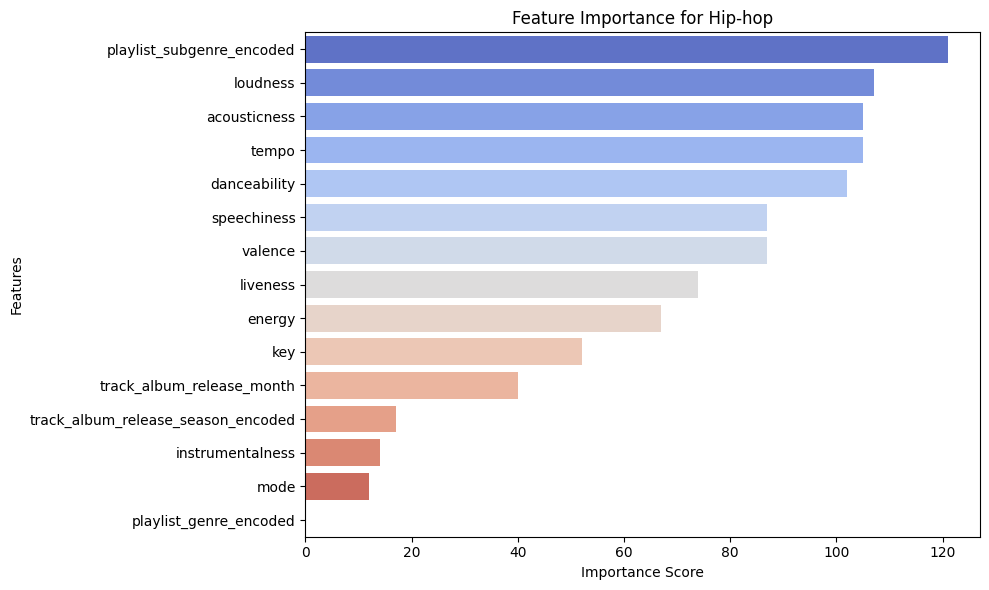

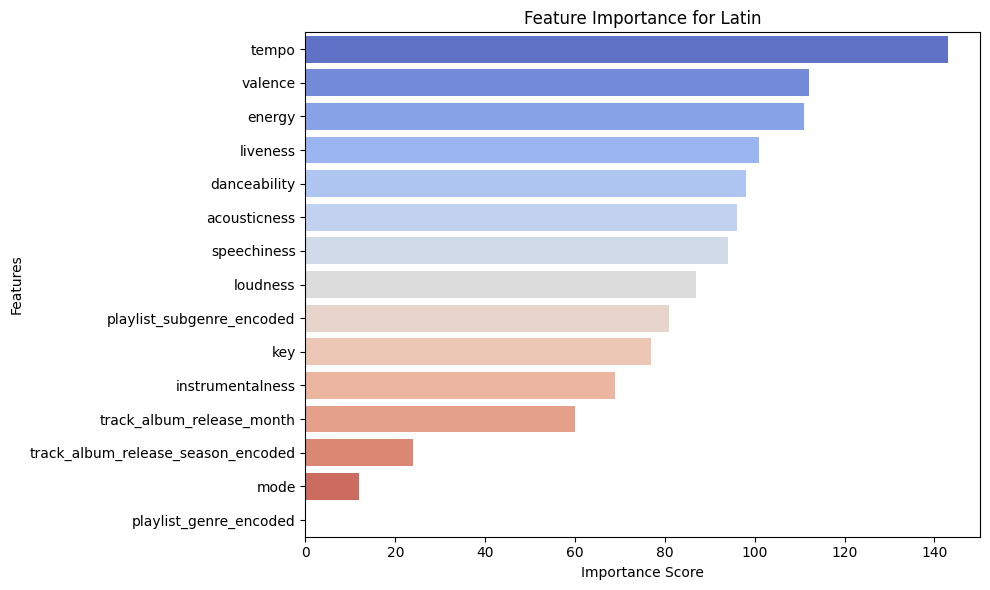

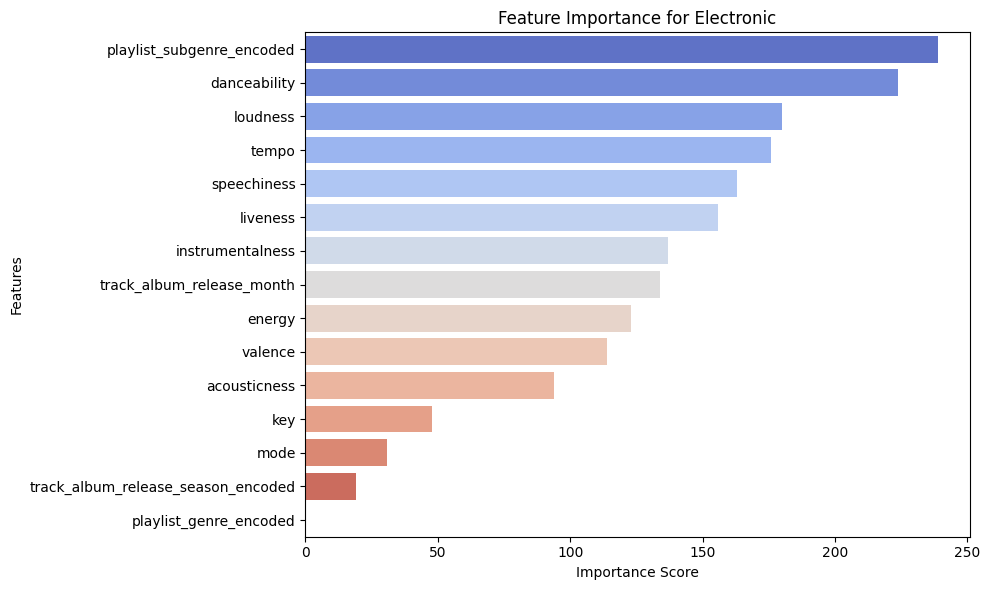

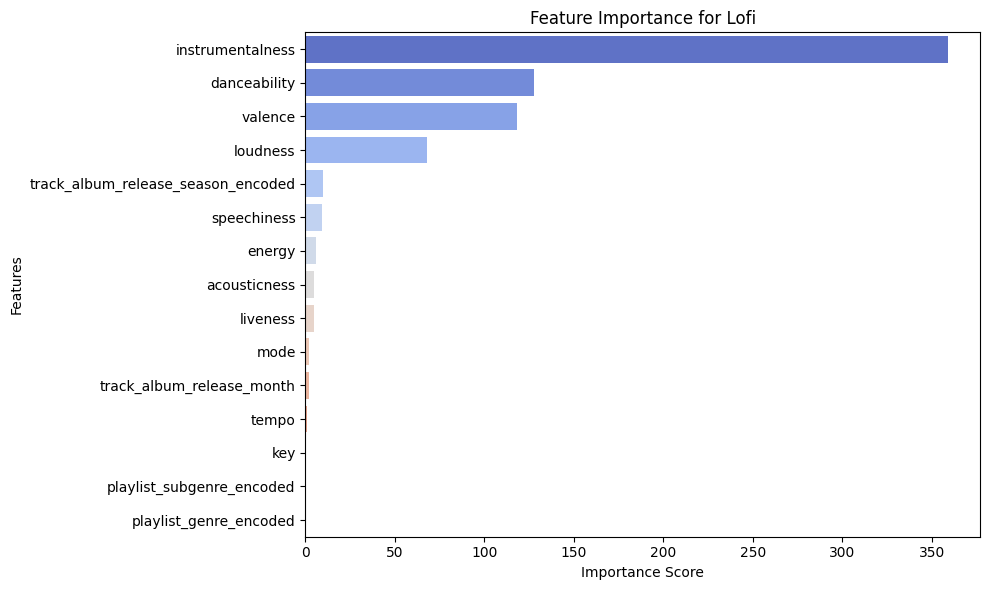

In [36]:
# Selected genres for analysis
selected_genres = ['pop', 'rock', 'hip-hop', 'latin', 'electronic', 'lofi']

genre_feature_importance = {}

for genre in selected_genres:
    print(f"Analyzing genre: {genre}")


    X = experiment_df[features]
    y = experiment_df['track_popularity_cat']
    
    genre_data = experiment_df[experiment_df['playlist_genre'] == genre]
    
    X = genre_data[features]
    y = genre_data['track_popularity_cat']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    genre_model = LGBMClassifier(random_state=42, verbosity=-1)
    genre_model.fit(X_train, y_train)

    print(genre_model.score(X_test, y_test))
    
    importance = genre_model.feature_importances_
    genre_feature_importance[genre] = pd.DataFrame({'Importance': importance, 'Features': features}).sort_values(by='Importance', ascending=False)

for genre, importance_df in genre_feature_importance.items():
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Features', data=importance_df, palette='coolwarm')
    plt.title(f'Feature Importance for {genre.capitalize()}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

The selected genres include Pop, Rock, Hip-hop, Latin, Electronic, and Lofi. For Pop music, the subgenre plays a major role in determining which songs end up more popular. However, for Rock, speechiness, liveness and loudness dominate, which makes sense as rock music is a genre characterized by loud features.  

Lofi, a genre known for its instrumental nature, prominently features "instrumentalness" as the most important feature, reflecting the minimalistic nature of this music style. Latin music, on the other hand, focuses on "tempo" and "valence," pointing to the energetic and positive vibe commonly associated with this genre. Electronic music, focuses primarily on danceability and this points to the common audience of this genre being clubs, social gatherings and concerts. 

From the results, it is evident that the driving factors behind track popularity vary significantly across genres. The conclusions and insights discovered in these results can better inform creatives in the different genre of music.

### **Research Question 2**


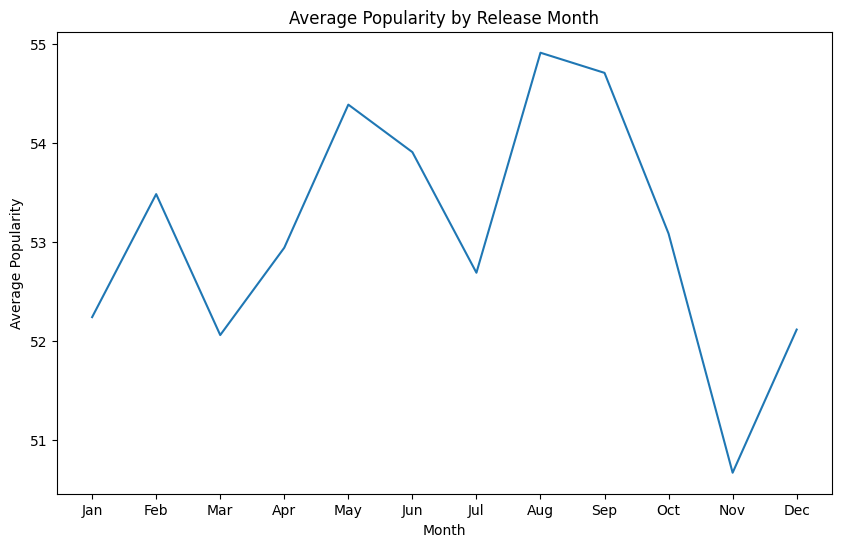

In [37]:
seasonal_df = experiment_df.groupby('track_album_release_month')['track_popularity'].mean().reset_index()
data=pd.DataFrame(seasonal_df)
plt.figure(figsize=(10, 6))
sns.lineplot(x='track_album_release_month', y='track_popularity', data=pd.DataFrame(seasonal_df))
plt.title('Average Popularity by Release Month')
plt.xlabel('Month')
plt.ylabel('Average Popularity')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

The results of this analysis can help inform release strategies for artists, music producers and record labels. The results point to September being the month with the most popular songs. An artist struggling to get streaming numbers can use this information and release the next project in the month with the most success. Further analysis is however required, to draw more insights for the different genres. 

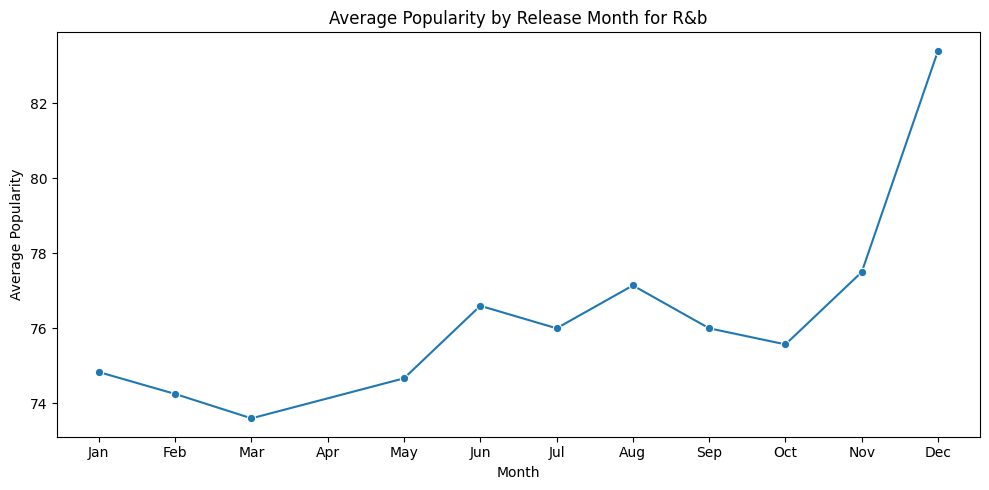

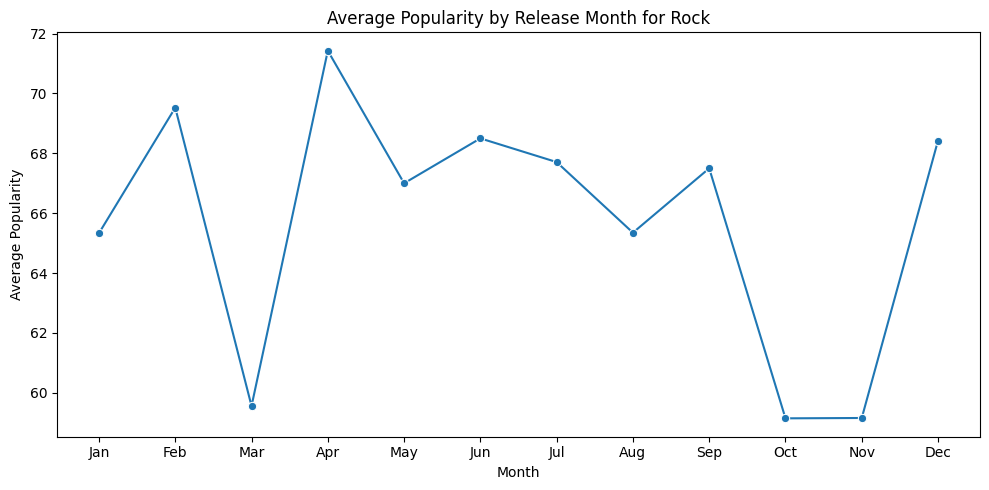

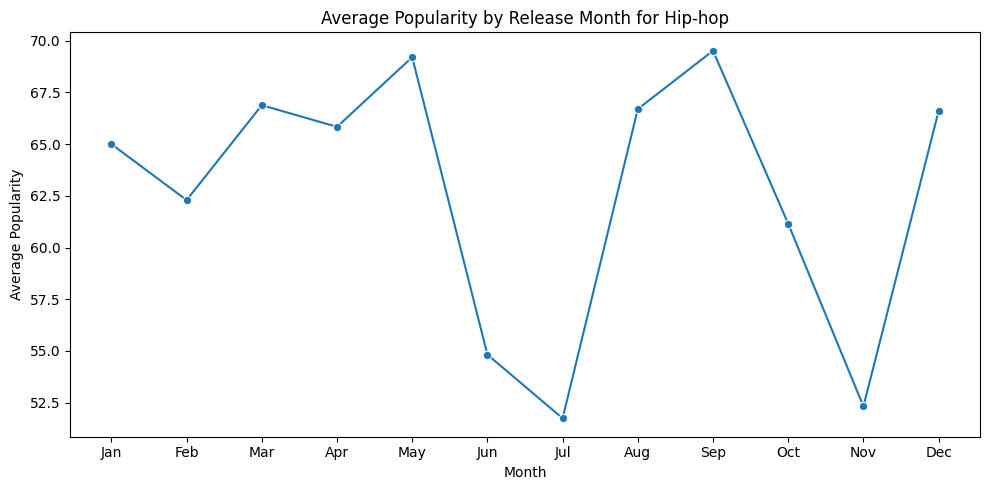

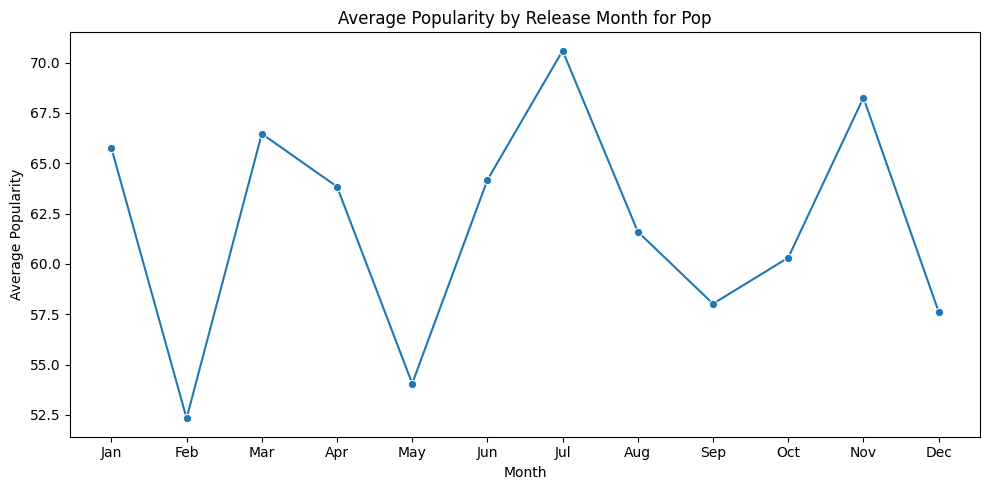

In [38]:
selected_genres = ['r&b','rock', 'hip-hop', 'pop']

for genre in selected_genres:
    genre_data = experiment_df[experiment_df['playlist_genre'] == genre]
    
    monthly_genre_popularity = genre_data.groupby('track_album_release_month')['track_popularity'].mean().reset_index()
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=monthly_genre_popularity, x='track_album_release_month', y='track_popularity', marker='o')
    plt.title(f'Average Popularity by Release Month for {genre.capitalize()}')
    plt.xlabel('Month')
    plt.ylabel('Average Popularity')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()


The results across the charts illustrate interesting patterns in how music popularity varies with release months across genres such as Rock, Hip-hop, Pop, and R&B. Each genre reveals unique preferences, which can provide valuable insights for music producers, streaming platforms, and marketers to optimize releases.

For Rock, the charts reveal that popularity peaks around March to April. This time period also falls within the march madness festival event timeline. This is a good example of how month of release can immensely affect the popularity of a song. 
R&B, in contrast to other genres, has a consistent rise in popularity as the year progresses, peaking sharply in December. This trend suggests R&B's strong association with the holiday season, as its soulful and romantic tones align well with festive or intimate settings. Its steady rise throughout the year reflects sustained engagement, making it an ideal genre for gradual promotions and late-year releases.

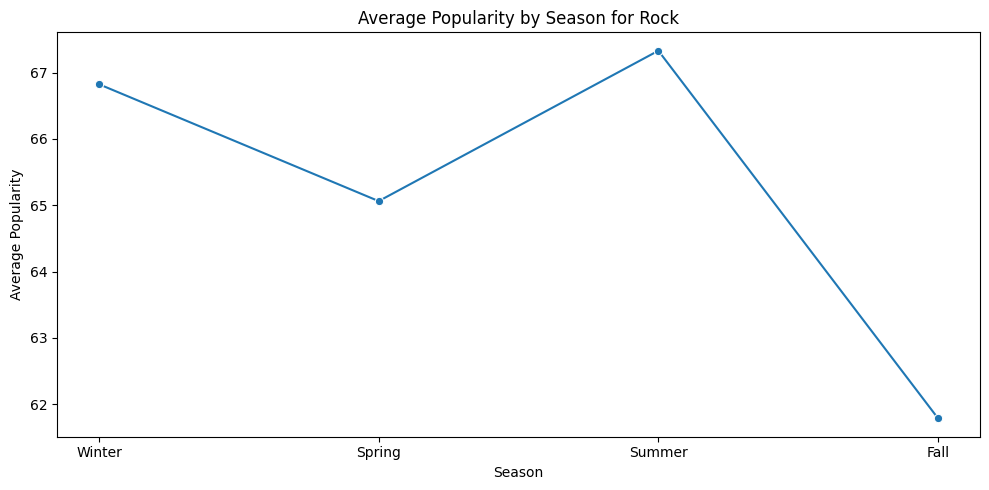

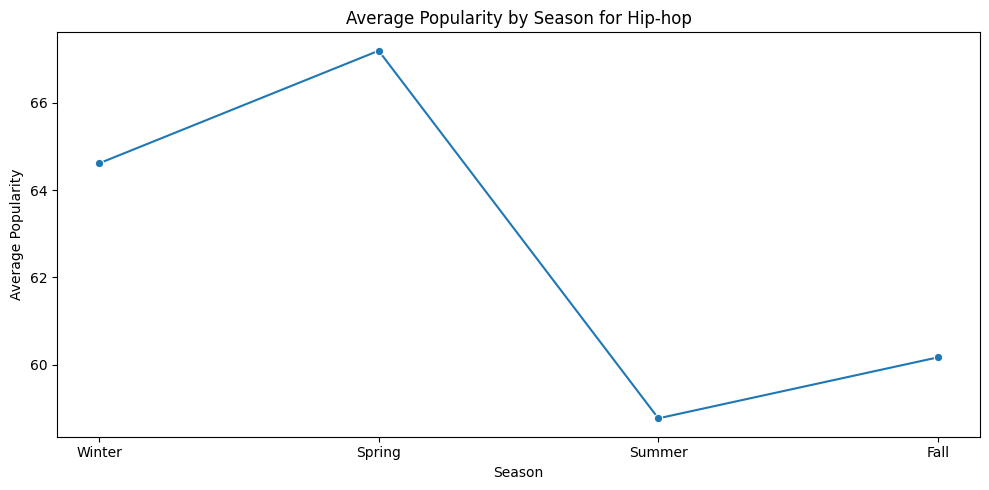

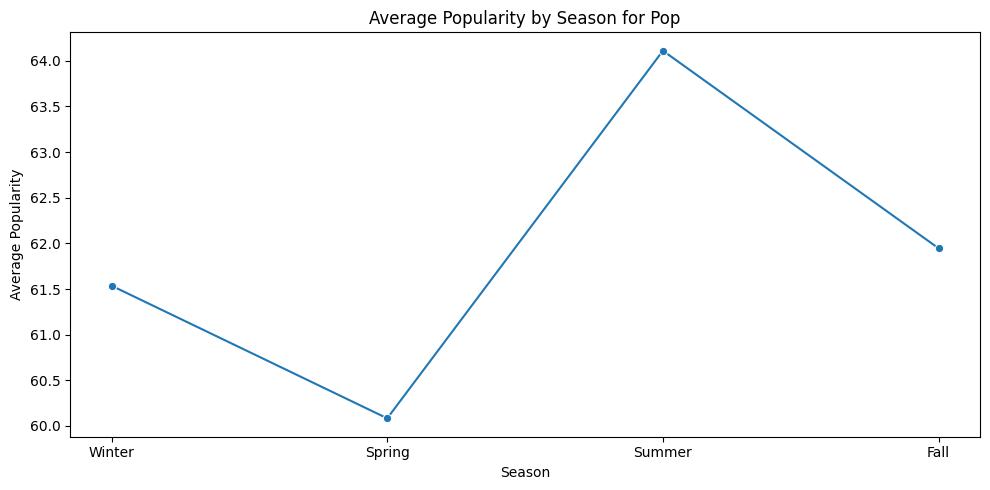

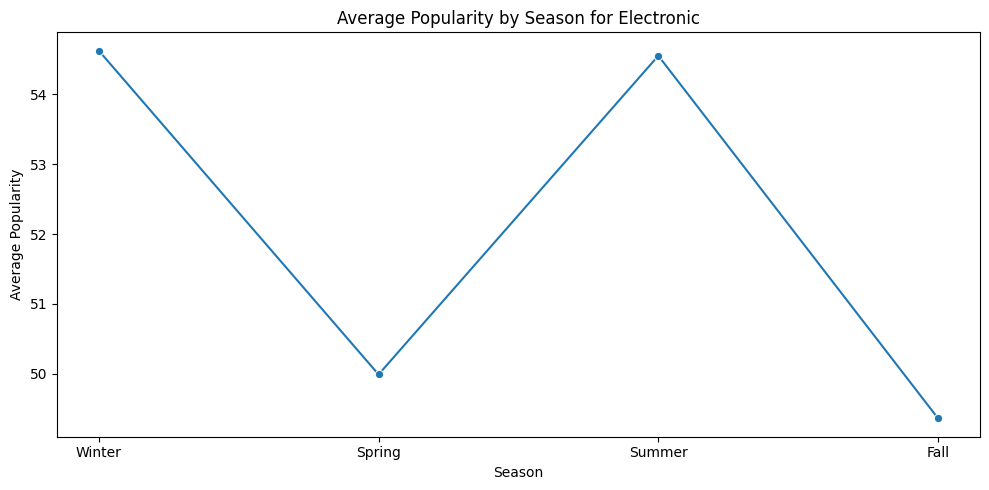

In [39]:
selected_genres = ['rock', 'hip-hop', 'pop', 'electronic']

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

experiment_df['track_album_release_season'] = experiment_df['track_album_release_month'].map(season_mapping)

for genre in selected_genres:
    genre_data = experiment_df[experiment_df['playlist_genre'] == genre]
    
    seasonal_genre_popularity = genre_data.groupby('track_album_release_season')['track_popularity'].mean().reset_index()
    
    season_order = ['Winter', 'Spring', 'Summer', 'Fall']
    seasonal_genre_popularity['track_album_release_season'] = pd.Categorical(
        seasonal_genre_popularity['track_album_release_season'], categories=season_order, ordered=True
    )
    seasonal_genre_popularity = seasonal_genre_popularity.sort_values('track_album_release_season')

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=seasonal_genre_popularity, x='track_album_release_season', y='track_popularity', marker='o')
    plt.title(f'Average Popularity by Season for {genre.capitalize()}')
    plt.xlabel('Season')
    plt.ylabel('Average Popularity')
    plt.tight_layout()
    plt.show()


Rock and Pop thrive in high-energy periods like Summer, while Hip-hop caters to a mix of introspective and lively periods in Winter and Spring. R&B uniquely peaks in late-year festive moments, highlighting its distinct emotional appeal. These insights could inform release strategies, marketing campaigns, and playlist curation to maximize listener engagement and chart performance.

### **Research Question 3**


In [40]:
high_popularity_data = experiment_df[experiment_df['track_popularity_cat'] == 1]
summary_stat = high_popularity_data[features].describe()

mode_values = summary_stat.mode().iloc[0]

print("\nMode Values for Features in High Popularity Class:")
print(mode_values)


Mode Values for Features in High Popularity Class:
danceability                           0.138000
energy                                 0.001610
key                                    0.000000
loudness                             -43.643000
mode                                   1.000000
speechiness                            0.023200
acousticness                           0.000013
instrumentalness                       0.000000
liveness                               0.021000
valence                                0.034800
tempo                                 27.096123
playlist_subgenre_encoded              0.000000
playlist_genre_encoded                 0.000000
track_album_release_season_encoded     0.000000
track_album_release_month              1.000000
Name: 0, dtype: float64


In [41]:
selected_genres = ['rock', 'pop', 'r&b', 'hip-hop']

high_popularity_data = experiment_df[experiment_df['track_popularity_cat'] == 1]

genre_mode_values = {}

for genre in selected_genres:
    genre_data = high_popularity_data[high_popularity_data['playlist_genre'] == genre]
    
    summary_stat = genre_data[features].describe()
    
    mode_df = genre_data[features].mode()
    
    mode_values = mode_df.iloc[0] 
    
    genre_mode_values[genre] = mode_values

for genre, mode_values in genre_mode_values.items():
    print(f"\nMode Values for Features in Genre {genre}:")
    print(mode_values)



Mode Values for Features in Genre rock:
danceability                           0.50200
energy                                 0.79500
key                                    0.00000
loudness                             -18.06400
mode                                   1.00000
speechiness                            0.02760
acousticness                           0.00178
instrumentalness                       0.00000
liveness                               0.10400
valence                                0.51800
tempo                                 74.98900
playlist_subgenre_encoded             22.00000
playlist_genre_encoded                29.00000
track_album_release_season_encoded     2.00000
track_album_release_month              1.00000
Name: 0, dtype: float64

Mode Values for Features in Genre pop:
danceability                            0.7290
energy                                  0.7110
key                                     1.0000
loudness                               -8.8240
mo

The results above show the values of audio features which are common in popular songs across genres. These represent optimal values that artists, producers and record labels can aim to achieve during production and release to ensure their songs end up  being hit songs. 

In [42]:
music_high_popularity = experiment_df[experiment_df['track_popularity_cat'] == 1]
mode_features = music_high_popularity[features].mode().iloc[0]

distances_to_mode = np.sqrt(((music_high_popularity[features] - mode_features) ** 2).sum(axis=1))

closest_tracks_to_mode_indices = distances_to_mode.argsort()[:20]
closest_tracks_to_mode = music_high_popularity.iloc[closest_tracks_to_mode_indices]

closest_tracks_info = closest_tracks_to_mode[['track_name', 'track_artist', 'track_popularity', 'playlist_genre']]
closest_tracks_info.columns = ['Track Name', 'Artist', 'Popularity', 'Genre']

print("Top 20 Tracks Closest to Mode Features:")
display(closest_tracks_info)


Top 20 Tracks Closest to Mode Features:


Track Name  \
281                              PIÉNSALO   
369                        Always On Time   
268      Kamikaze (feat. Victor Mendivil)   
1106                            Two Faced   
366                                No One   
362                       The Boy Is Mine   
43                                    +57   
372                           U Remind Me   
283                               Soltera   
385                                 Trust   
271                             DEPORTIVO   
355                             Best Time   
41                            Not Like Us   
359                        Nobody Gets Me   
265                       Después De La 1   
276                             Nueva Era   
277                             PELIGROSA   
356   Could've Been (feat. Bryson Tiller)   
351                         Family Affair   
27                         No One Noticed   

                                                 Artist  Popularity  Genre  
281                                            Junior H          84  latin  
369                                    Ja Rule, Ashanti          72    r&b  
268   Natanael Cano, Uriel Gaxiola, Ganggy, Victor M...          72  latin  
1106                                        Linkin Park          79   rock  
366                                         Alicia Keys          76    r&b  
362                                      Brandy, Monica          73    r&b  
43    KAROL G, Feid, DFZM, Ovy On The Drums, J Balvi...          84    pop  
372                                               USHER          69    r&b  
283                                             Shakira          86  latin  
385                                        Brent Faiyaz          75    r&b  
271                                    Blessd, Anuel AA          72  latin  
355                                        Brent Faiyaz          80    r&b  
41                                       Kendrick Lamar          88    pop  
359                                                 SZA          84    r&b  
265                          Cris Mj, FloyyMenor, LOUKI          86  latin  
276                                   Duki, Myke Towers          82  latin  
277                                          FloyyMenor          81  latin  
356                               H.E.R., Bryson Tiller          75    r&b  
351                                       Mary J. Blige          78    r&b  
27                                           The Marías          84    pop

### **Deployment**

In [43]:
def select_features(X):
    return X[features] 
feature_selector = FunctionTransformer(select_features)

In [44]:
final_model = Pipeline(steps=[
    ('date_pipeline', date_pipeline),
    ('encoding_pipeline', encoding_pipeline),
    ('feature_selector', feature_selector),
    ('model', best_lgbm_model)      
])
final_model

Pipeline(steps=[('date_pipeline',
                 Pipeline(steps=[('to_datetime',
                                  FunctionTransformer(func=<function convert_to_datetime at 0x7e64c5c695a0>)),
                                 ('extract_year_month',
                                  FunctionTransformer(func=<function extract_year_and_month at 0x7e64c5c69ab0>)),
                                 ('classify_seasons',
                                  FunctionTransformer(func=<function classify_seasons at 0x7e64c5c69b40>))])),
                ('encoding_pipeline',
                 P...
                                 ('encode_album_release_season',
                                  FunctionTransformer(func=<function encode_album_release_season at 0x7e64c5c69e10>))])),
                ('feature_selector',
                 FunctionTransformer(func=<function select_features at 0x7e64c2d7cc10>)),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8, max_depth=10,
                                min_child_weight=3, n_estimators=300,
                                num_leaves=40, reg_alpha=0.1, reg_lambda=10,
                                scale_pos_weight=2, subsample=0.7))])

In [45]:
joblib.dump(final_model, 'spotify_model.pkl')

['spotify_model.pkl']

### **Conclusion**

This project set out to understand the factors that make hit songs analyzing a spotify dataset of audio features, track popularity and descriptive features. The goal is to answer questions about what makes certain songs more likely to succeed and to find patterns that explain these successes, so the success can be continually repeated. Through the completion of this mining project, I have been able to discover what features are most important to the creation of hit songs. Insights about the importance of release dates, seasons and genre of music production are also some contributions this work makes to the exploration of hit songs. The formula for music success is a combination of all these insights; by identifying what genre is most primed for success, optimizing song production so as to land around the mode values for popular songs in that genre, releasing projects around their peak times and also placing focus on what features make the most impact in that genre. These results from this exploration do not only answer the research questions but also provide a solid foundation for further discussions in the music industry.

### **Future Work**

This study has successfully answered questions that can better inform music production, however to make a robust model, and in future iterations of this project, I plan to explore the following areas.

* Research how prominent artists impact a song’s popularity. For example, a claim that can be explored is how much having a globally recognized artist like Drake, JCole or Adele on a track often boosts it's chances of success. Exploring data that holds this information could reveal how much of a contribution collaborations are to the success of a music career.

* Music tastes often vary by region, and tailored analysis for different regions could yield more streamlined results. For instance, Afrobeats has a stronghold in Nigeria, and Latin music thrives in Spanish-speaking countries. Analyzing popularity figures for individual regions could be very useful for smallscale local artists who may be under-represented by this model and also for artists and labels targeting particular markets.

* Exploring the impact of marketing and release budgets on how songs perform. Future studies could focus on gathering data about promotional campaigns, social media advertising, and release budgets to understand their influence on a song’s success. Combining this with the audio and descriptive features in this current model would unlock better insights into what gives a hit song.

* Another area worth exploring is the effect of fan engagement and social media trends on popularity. Viral moments, such as TikTok challenges or trending hashtags, can sometimes catapult a song to the top of the charts. Analyzing this data alongside audio features could provide a more complete understanding of what makes a song successful [6].

### **References**

* [1] Schopenhauer: why music is the greatest and noblest of all art forms. (2024). Retrieved October 30, 2024, from https://bigthink.com/high-culture/schopenhauer-music-will/
* [2] Spotify Comfortably Remains the Biggest Streaming Service Despite Its Market Share Being Eaten Into. (2024). Retrieved October 30, 2024, from https://www.forbes.com/sites/eamonnforde/2022/01/19/spotify-comfortably-remains-the-biggest-streaming-service-despite-its-market-share-being-eaten-into/
* [3] Dawson Jr, C. E., Mann, S., Roske, E., Vasseur, G., Jr, C. E., & Dawson, C. (2021). Spotify: You have a Hit! In SMU Data Science Review (Vol. 5, Issue 3).
* [4] Joakim Arvidsson. (2023). 30000 Spotify Songs. https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs/data
* [5] Ke, G., Meng, Q., Finley, T., Wang, T., Chen, W., Ma, W., Ye, Q., & Liu, T.-Y. (2017). LightGBM: A Highly Efficient Gradient Boosting Decision Tree. https://github.com/Microsoft/LightGBM.
* [6] Kah Yee, Y., & Raheem, M. (2022). INDIAN JOURNAL OF SCIENCE AND TECHNOLOGY Predicting Music Popularity Using Spotify and YouTube Features. Indian Journal of Science and Technology, 15(36), 1786–1799. https://doi.org/10.17485/IJST/v15i36.2332
* [7] Roman Nikiforov (2024). Creativity Is 4 LOSERS. Science To Find HIT Song https://www.kaggle.com/code/romanniki/creativity-is-4-losers-science-to-find-hit-song
